In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import csv
from sklearn.feature_selection import SelectPercentile
from sklearn.svm import SVC
from sklearn import utils
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
import warnings
import pickle

In [2]:
def fea(aalFeaPer,aalFeaSel,aalFeaRid,p,s,r,allnum):
    feature_per = feaSel(aalFeaPer,allnum,p)
    feature_sel = feaSel(aalFeaSel,allnum,s)
    feature_rid = feaSel(aalFeaRid,allnum,r)
    features = set(feature_per) & set(feature_sel) & set(feature_rid)
    features = list(features)
    return features,len(features)

def feaSel(aalFeaPer,bigW,pinlv):
    aalFeaPer.value_counts()
    lie = list(aalFeaPer.values)
    feature_per = []
    for i in range(1, bigW+1):
        if lie[i - 1] >= pinlv:
            feature_per.append(i)
    return feature_per

def k_fold_split(dataset,k_fold,k):
    k_sample_count = dataset.shape[0]//k_fold
    test_begin = k_sample_count*k
    test_end = k_sample_count*(k+1)
    test_data = dataset[test_begin:test_end]
    train_data = pd.concat([dataset[:test_begin],dataset[test_end:]])
    return train_data,test_data

def data_spilt(dataset):
    dataset = dataset.drop("SUB_ID",axis=1)
    dataset = dataset.drop("SITE_ID", axis=1)
    ill_data = dataset[dataset["label"]==1]
    ill_data = utils.shuffle(ill_data,random_state=0)
    unill_data = dataset[dataset["label"]==2]
    unill_data = utils.shuffle(unill_data,random_state=0)
    return ill_data,unill_data

def dataConcat(ill_data,unill_data,k_fold,k):
    train_data1, test_data1 = k_fold_split(ill_data, k_fold, k)
    train_data2, test_data2 = k_fold_split(unill_data, k_fold, k)
    train_data = pd.concat([train_data1, train_data2])
    test_data = pd.concat([test_data1, test_data2])
    train_data = utils.shuffle(train_data, random_state=0)
    test_data = utils.shuffle(test_data, random_state=0)
    return train_data,test_data

def dataProcess(train_data,test_data,weidu):
    traindata_dummies = pd.get_dummies(train_data)
    # print("Features after get_dummies:\n",list(traindata_dummies.columns))
    train_features = traindata_dummies.iloc[:,:weidu]
    X_train = train_features.values
    # print(np.shape(X_train))
    y_train = traindata_dummies.iloc[:,-1].values
    testdata_dummies = pd.get_dummies(test_data)
    test_features = testdata_dummies.iloc[:,:weidu]
    X_test = test_features.values
    y_test = testdata_dummies.iloc[:,-1].values
    # print(np.shape(X_test))
    return X_train,X_test,y_train,y_test

In [3]:
def feadata(aal_fea,weidu0,cc200_fea,weidu1):
    aal_fea = list(map(str, aal_fea))
    aal_fea.insert(0, 'SUB_ID')
    aal_fea.insert(1, "SITE_ID")
    cc200_fea = list(map(str, cc200_fea))
    cc200_fea.insert(0, 'SUB_ID')
    weidu = weidu0 + weidu1
    raw_data0 = pd.read_csv("aal_data.csv")
    raw_data1 = pd.read_csv("cc200_data.csv")
    data0 = pd.DataFrame(raw_data0, columns=aal_fea)
    data1 = pd.DataFrame(raw_data1, columns=cc200_fea)
    data = pd.merge(data0, data1, on='SUB_ID', how='inner')
    label = []
    for i in data["SUB_ID"].values:
        if i in phenotype_data["SUB_ID"].values:
            index = np.where(phenotype_data["SUB_ID"].values == i)
            label.append(phenotype_data["DX_GROUP"].values[index][0])
    data.insert(loc=len(data.columns), column="label", value=label)
    return data,weidu

def trainTest(data,weidu,aals,aalr,ccs,ccr):
    test_score = []
    train_score = []
    precision = []
    recall = []
    f1 = []
    auc = []
    site_list = ['NYU', 'UM_1', 'UCLA_1', 'USM', 'TRINITY', 'PITT']
    for k in range(k_fold):
        train_data_list = []
        test_data_list = []
        for site in site_list:
            ill_data, unill_data = data_spilt(data[data["SITE_ID"] == site])
            train, test = dataConcat(ill_data, unill_data, k_fold, k)
            train_data_list.append(train)
            test_data_list.append(test)
        train_data = pd.concat(
            [train_data_list[0], train_data_list[1], train_data_list[2], train_data_list[3], train_data_list[4],
             train_data_list[5]])
        test_data = pd.concat(
            [test_data_list[0], test_data_list[1], test_data_list[2], test_data_list[3], test_data_list[4],
             test_data_list[5]])
        train_data = utils.shuffle(train_data, random_state=0)
        test_data = utils.shuffle(test_data, random_state=0)
        X_train, X_test, y_train, y_test = dataProcess(train_data, test_data, weidu)
        # print('逻辑回归')
        model = LogisticRegression(max_iter=1000, random_state=0, class_weight={1: 0.65, 2: 0.35})
        # print('随机森林')
        # model = RandomForestClassifier(n_estimators=35, max_depth=7, random_state=0)
        # print('svm')
        # model = SVC(gamma=0.1, C=10, class_weight={1: 0.65, 2: 0.35})
        model.fit(X_train, y_train)
        # f = open(r'F:\fmri\fmri-new\machine\multSite\modle\double\svm'+str(aals)+str(aalr)+str(ccs)+str(ccr) +'\\'+str(k)+".pkl",'wb')
        # pickle.dump(model,f)
        # f.close()
        y_predict = model.predict(X_test)
        # print("y_predict",y_predict)
        # print("y_test",y_test)
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))
        precision.append(precision_score(y_test, y_predict, average='binary'))
        recall.append(recall_score(y_test, y_predict, average='binary'))
        f1.append(f1_score(y_test, y_predict, average='binary'))
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict, pos_label=2)
        auc.append(metrics.auc(fpr, tpr))
    train_acc = np.mean(train_score)
    train_var = np.var(train_score)
    test_acc = np.mean(test_score)
    test_var = np.var(test_score)
    pre = np.mean(precision)
    pre_var = np.var(precision)
    rec = np.mean(recall)
    rec_var = np.var(recall)
    f1_sc = np.mean(f1)
    f1_var = np.var(f1)
    auc_score = np.mean(auc)
    auc_var = np.var(auc)
    return train_acc, test_acc, pre, rec, f1_sc, auc_score, train_var, test_var, pre_var, rec_var, f1_var, auc_var

def resHanshu(aals,aalr,ccs,ccr):
    aal_fea, weidu0 = fea(aalFeaPer, aalFeaSel, aalFeaRid, 10, aals, aalr,6670)
    cc200_fea, weidu1 = fea(ccFeaPer, ccFeaSel, ccFeaRid, 10, ccs, ccr,19900)
    data, weidu = feadata(aal_fea, weidu0, cc200_fea, weidu1)
    print("aals",aals,"aalr",aalr,"ccs",ccs,"ccr",ccr,weidu)
    train_acc, test_acc, pre, rec, f1_sc, auc_score,train_var,test_var,pre_var,rec_var,f1_var,auc_var = trainTest(data,weidu,aals,aalr,ccs,ccr)
    return train_acc, test_acc, pre, rec, f1_sc, auc_score,weidu,train_var,test_var,pre_var,rec_var,f1_var,auc_var

In [5]:
warnings.filterwarnings("ignore")
k_fold = 10
phenotype_data = pd.read_csv("../Phenotypic_V1_0b.csv")
root_path0 = r"F:\fmri\fmri-new\machine\multSite\aal"
root_path1 = r"F:\fmri\fmri-new\machine\multSite\cc200"
aalFeaPer = pd.read_csv("res/aal/csv/aalMultPerPinlv.csv", header=None)
aalFeaSel = pd.read_csv("res/aal/csv/aalMultSelPinlv.csv", header=None)
aalFeaRid = pd.read_csv("res/aal/csv/aalMultRidPinlv.csv", header=None)
ccFeaPer = pd.read_csv("res/cc200/csv/cc200MultPerPinlv.csv", header=None)
ccFeaSel = pd.read_csv("res/cc200/csv/cc200MultSelPinlv.csv", header=None)
ccFeaRid = pd.read_csv("res\cc200\csv\cc200MultRidPinlv.csv", header=None)

In [6]:
# logistic方法数据
aalLogS = [3,2,1,3,2,1,3,2]
aalLogR = [3,3,3,2,2,2,1,1]
cclogS = [1,1,4,2,1,3,1,1]
cclogR = [6,5,1,3,3,1,2,1]
aaZipList = list(zip(aalLogS,aalLogR))
ccZipList = list(zip(cclogS,cclogR))
xx = [66,69,71,80,83,85,121,127]
yy = [33,55,69,72,98,110,131,208]

In [7]:
X, Y = np.meshgrid(xx, yy)
Train_ACC = np.zeros((len(xx),len(yy)))
Test_ACC = np.zeros((len(xx),len(yy)))
Precision = np.zeros((len(xx),len(yy)))
Recall = np.zeros((len(xx),len(yy)))
F1 = np.zeros((len(xx),len(yy)))
AUC = np.zeros((len(xx),len(yy)))
Train_VAR = np.zeros((len(xx),len(yy)))
Test_VAR = np.zeros((len(xx),len(yy)))
Precision_VAR = np.zeros((len(xx),len(yy)))
Recall_VAR = np.zeros((len(xx),len(yy)))
F1_VAR = np.zeros((len(xx),len(yy)))
AUC_VAR = np.zeros((len(xx),len(yy)))
weiduMatrix = np.zeros((len(xx),len(yy)))


for i in range(len(aaZipList)):
    for j in range(len(ccZipList)):
        aals = aaZipList[i][0]
        aalr = aaZipList[i][1]
        ccs = ccZipList[j][0]
        ccr = ccZipList[j][1]
        Train_ACC[i][j], Test_ACC[i][j], Precision[i][j], \
            Recall[i][j], F1[i][j], AUC[i][j], weiduMatrix[i][j], \
            Train_VAR[i][j], Test_VAR[i][j], Precision_VAR[i][j], \
            Recall_VAR[i][j], F1_VAR[i][j], AUC_VAR[i][j] = resHanshu(aals, aalr, ccs, ccr)

aals 3 aalr 3 ccs 1 ccr 6 99
aals 3 aalr 3 ccs 1 ccr 5 121
aals 3 aalr 3 ccs 4 ccr 1 135
aals 3 aalr 3 ccs 2 ccr 3 138
aals 3 aalr 3 ccs 1 ccr 3 164
aals 3 aalr 3 ccs 3 ccr 1 176
aals 3 aalr 3 ccs 1 ccr 2 197
aals 3 aalr 3 ccs 1 ccr 1 274
aals 2 aalr 3 ccs 1 ccr 6 102
aals 2 aalr 3 ccs 1 ccr 5 124
aals 2 aalr 3 ccs 4 ccr 1 138
aals 2 aalr 3 ccs 2 ccr 3 141
aals 2 aalr 3 ccs 1 ccr 3 167
aals 2 aalr 3 ccs 3 ccr 1 179
aals 2 aalr 3 ccs 1 ccr 2 200
aals 2 aalr 3 ccs 1 ccr 1 277
aals 1 aalr 3 ccs 1 ccr 6 104
aals 1 aalr 3 ccs 1 ccr 5 126
aals 1 aalr 3 ccs 4 ccr 1 140
aals 1 aalr 3 ccs 2 ccr 3 143
aals 1 aalr 3 ccs 1 ccr 3 169
aals 1 aalr 3 ccs 3 ccr 1 181
aals 1 aalr 3 ccs 1 ccr 2 202
aals 1 aalr 3 ccs 1 ccr 1 279
aals 3 aalr 2 ccs 1 ccr 6 113
aals 3 aalr 2 ccs 1 ccr 5 135
aals 3 aalr 2 ccs 4 ccr 1 149
aals 3 aalr 2 ccs 2 ccr 3 152
aals 3 aalr 2 ccs 1 ccr 3 178
aals 3 aalr 2 ccs 3 ccr 1 190
aals 3 aalr 2 ccs 1 ccr 2 211
aals 3 aalr 2 ccs 1 ccr 1 288
aals 2 aalr 2 ccs 1 ccr 6 116
aals 2 aalr

In [8]:
Train_ACC0=list(Train_ACC.flatten())
Test_ACC0=list(Test_ACC.flatten())
Precision0=list(Precision.flatten())
Recall0=list(Recall.flatten())
F10=list(F1.flatten())
AUC0=list(AUC.flatten())
Train_VAR = list(Train_VAR.flatten())
Test_VAR = list(Test_VAR.flatten())
Precision_VAR = list(Precision_VAR.flatten())
Recall_VAR = list(Recall_VAR.flatten())
F1_VAR = list(F1_VAR.flatten())
AUC_VAR = list(AUC_VAR.flatten())
weiduMatrix=list(weiduMatrix.flatten())
weiduMatrix,Train_ACC0,Test_ACC0,Precision0,Recall0,F10,AUC0,\
    Train_VAR,Test_VAR,Precision_VAR,Recall_VAR,F1_VAR,AUC_VAR = \
    (list(t) for t in zip(*sorted(zip(weiduMatrix,Train_ACC0,Test_ACC0,
                                      Precision0,Recall0,F10,AUC0,Train_VAR,Test_VAR,
                                      Precision_VAR,Recall_VAR,F1_VAR,AUC_VAR))))

In [ ]:
# with open("res/double/double_Mult_log_all.csv", "w") as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['weiduMatrix'] + weiduMatrix)
#     writer.writerow(['Train_ACC'] + Train_ACC0)
#     writer.writerow(["train_var"] + Train_VAR)
#     writer.writerow(['Test_ACC'] + Test_ACC0)
#     writer.writerow(["Test_VAR"] + Test_VAR)
#     writer.writerow(['Precision'] + Precision0)
#     writer.writerow(["Precision_VAR"] + Precision_VAR)
#     writer.writerow(['Recall'] + Recall0)
#     writer.writerow(["Recall_VAR"] + Recall_VAR)
#     writer.writerow(['F1'] + F10)
#     writer.writerow(["F1_VAR"] + F1_VAR)
#     writer.writerow(['AUC'] + AUC0)
#     writer.writerow(["AUC_VAR"] + AUC_VAR)

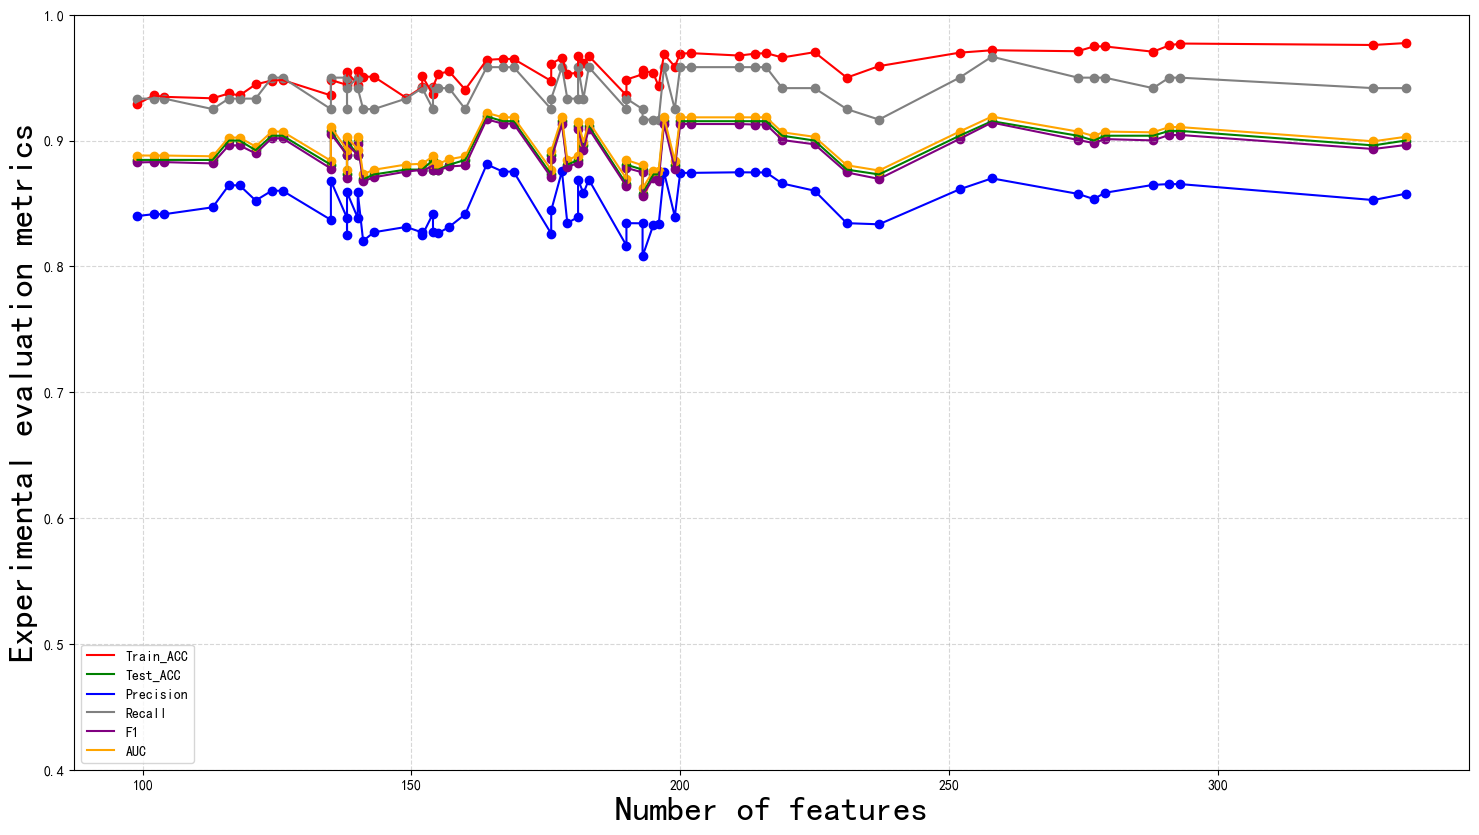

In [9]:
plt.rcParams.update({'font.size': 25})
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(18, 10), dpi=100)
plt.plot(weiduMatrix, Train_ACC0,c = 'red',label = "Train_ACC")
plt.plot(weiduMatrix, Test_ACC0,c = 'green',label = "Test_ACC")
plt.plot(weiduMatrix, Precision0,c = 'blue',label = "Precision")
plt.plot(weiduMatrix, Recall0,c = 'grey',label = "Recall")
plt.plot(weiduMatrix, F10,c = 'purple',label = "F1")
plt.plot(weiduMatrix, AUC0,c = 'orange',label = "AUC")
#
plt.scatter(weiduMatrix, Train_ACC0, c='red')
plt.scatter(weiduMatrix, Test_ACC0, c='green')
plt.scatter(weiduMatrix, Precision0, c='blue')
plt.scatter(weiduMatrix, Recall0, c='grey')
plt.scatter(weiduMatrix, F10, c='purple')
plt.scatter(weiduMatrix, AUC0, c='orange')
plt.legend(loc='best')

plt.ylim(0.4, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Number of features", fontdict={'size': 25})
plt.ylabel("Experimental evaluation metrics", fontdict={'size': 25})
# plt.title("Random forest method dual atlas feature fusion number and evaluation index results", fontdict={'size': 20})
plt.show()

In [11]:
doubleLog = pd.read_csv("res/double/double_Mult_log_all.csv",index_col=0)
doubleLog.sort_values(by="Test_ACC",ascending=False,axis = 1).head(12)

,164.0,178.0,200.0,211.0,214.0,216.0,202.0,258.0,169.0,167.0,...,193.0,237.0,176.0,196.0,143.0,138.0.1,195.0,141.0,190.0,193.0.1
weiduMatrix,,,,,,,,,,,,,,,,,,,,,
Train_ACC,0.964122,0.965649,0.969084,0.967557,0.969084,0.969466,0.969466,0.971756,0.964885,0.964885,...,0.952672,0.959160,0.947328,0.943130,0.950763,0.948092,0.953435,0.950763,0.935878,0.955725
train_var,0.000015,0.000012,0.000013,0.000009,0.000019,0.000017,0.000017,0.000021,0.000020,0.000020,...,0.000015,0.000021,0.000031,0.000048,0.000019,0.000024,0.000011,0.000019,0.000023,0.000050
Test_ACC,0.919231,0.915385,0.915385,0.915385,0.915385,0.915385,0.915385,0.915385,0.915385,0.915385,...,0.876923,0.873077,0.873077,0.873077,0.873077,0.873077,0.873077,0.869231,0.865385,0.857692
Test_VAR,0.001317,0.001420,0.002308,0.002012,0.002308,0.002308,0.002308,0.002899,0.001420,0.001420,...,0.002899,0.002973,0.003565,0.002382,0.003565,0.001790,0.002973,0.004201,0.001849,0.001198
Precision,0.881044,0.875671,0.874322,0.874780,0.874664,0.874664,0.874322,0.869963,0.875330,0.875330,...,0.834224,0.833443,0.826007,0.833303,0.827125,0.824634,0.832942,0.820307,0.816538,0.808015
Precision_VAR,0.003055,0.003513,0.004000,0.003892,0.003892,0.003892,0.004000,0.005033,0.003622,0.003622,...,0.005332,0.005193,0.005005,0.003925,0.004863,0.002382,0.005316,0.005403,0.004013,0.003049
Recall,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.966667,0.958333,0.958333,...,0.925000,0.916667,0.925000,0.916667,0.925000,0.925000,0.916667,0.925000,0.925000,0.916667
Recall_VAR,0.001736,0.003125,0.003125,0.003125,0.004514,0.004514,0.003125,0.003056,0.001736,0.001736,...,0.004792,0.006944,0.006181,0.009722,0.006181,0.004792,0.005556,0.006181,0.006181,0.004167
F1,0.916846,0.913025,0.913145,0.913120,0.912743,0.912743,0.913145,0.914304,0.913427,0.913427,...,0.874667,0.869518,0.870711,0.868209,0.870829,0.870208,0.870000,0.867568,0.863626,0.856123
